# Damage sensor optimization using FNO model and Genetic Algorithm


In [2]:
# load packages
from pathlib import Path
from neuralop.models import FNO
from nopkit.data import load_damage_sensor_dataset
from nopkit.opt import GeneticAlgorithm, plot_fitness_curve, plot_best_layouts
from nopkit.mask import MaskGenerator

device = 'cpu'

In [5]:
# load data
data_dir = Path("../data/damage_sensor")

train_loader, test_loaders, data_processor = load_damage_sensor_dataset(
    ramps_path=data_dir / "ramps_n500_res32.pt",
    damage_path=data_dir / "damage_n500_t175_res32.pt",
    defgrad_path=data_dir / "defgrad_n500_t175_res32.pt",
    elec_path=data_dir / "elec_n500_t175_res32.pt",
    masks_path=data_dir / "masks5_uniform.pt", # this is only used to load data
    n_train=450, # 450 out of 500
    batch_size=5,
    test_batch_sizes=[10],
    test_resolutions=[32],
    encode_input=True,
    encode_output=True,
)
test_db = test_loaders[32].dataset

Loaded RAMPs      -> ..\data\damage_sensor\ramps_n500_res32.pt,	(torch.Size([500, 32, 32]))
Loaded damage     -> ..\data\damage_sensor\damage_n500_t175_res32.pt,	(torch.Size([500, 32, 32, 175]))
Loaded defgrad    -> ..\data\damage_sensor\defgrad_n500_t175_res32.pt,	(torch.Size([500, 32, 32, 175]))
Loaded elec field -> ..\data\damage_sensor\elec_n500_t175_res32.pt,	(torch.Size([500, 32, 32, 175]))
Loaded masks      -> ..\data\damage_sensor\masks5_uniform.pt,	(torch.Size([5, 32, 32]))
Loading total samples: 500, total masks: 5
Loading train db: 450 samples, test db: 50 samples
Train input shape: torch.Size([450, 3, 32, 32, 175]), Train output shape: torch.Size([450, 3, 32, 32, 175])
Test input shape: torch.Size([50, 3, 32, 32, 175]), Test output shape: torch.Size([50, 3, 32, 32, 175])


In [6]:
# load model
model = FNO.from_checkpoint("../damage_sensor/model", save_name="fno3d_masks5_uniform")

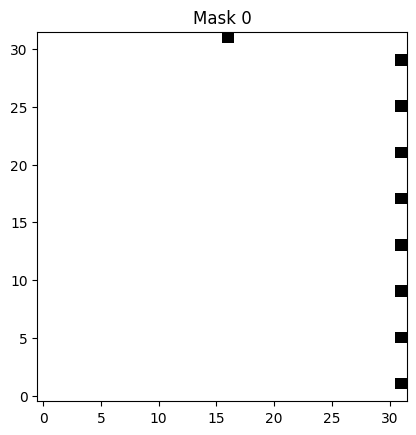

In [10]:
# first gen layout
# pos = [
#     (31, 16),
#     (1, 31), (3, 31), (5, 31), (7, 31), (9, 31), (11, 31), (13, 31), (15, 31),
#     (17, 31), (19, 31), (21, 31), (23, 31), (25, 31), (27, 31), (29, 31), (31, 31)
# ]
pos = [
    (31, 16),
    (1, 31), (5, 31), (9, 31), (13, 31),
    (17, 31), (21, 31), (25, 31), (29, 31),
]

gen = MaskGenerator(grid_shape=(32, 32))
mask = gen.generate_from_positions([pos])
gen.plot()

In [12]:
# setup and run GA
save_dir = Path("./history/")
save_dir.mkdir(exist_ok=True, parents=True)

print("Setting up GA...")
ga = GeneticAlgorithm(
    test_db=test_db,
    model=model,
    data_processor=data_processor,
    device=device,
    num_sensors_range=(5, 17),
    # initial_individual=pos,
    grid_size_x=32,
    grid_size_y=32,
    lambda_factor=0,
    pop_size=10,          # small population for quick test
    gen_size=10,           # only a few generations for testing
    cxpb=0.8,
    mutpb=0.8,
)

print("Running GA...")
ga.run_ga()

Setting up GA...
Running GA...
Initial evaluation...
gen	nevals	min        	avg        
0  	10    	1.09675e-10	1.14039e-10

Generation 1 start...
  Evaluating 10 offspring...
1  	10    	1.0852e-10 	1.12146e-10

Generation 2 start...
  Evaluating 8 offspring...
2  	8     	1.08482e-10	1.10425e-10

Generation 3 start...
  Evaluating 10 offspring...
3  	10    	1.0852e-10 	1.10049e-10

Generation 4 start...
  Evaluating 10 offspring...
4  	10    	1.0852e-10 	1.09369e-10

Generation 5 start...
  Evaluating 10 offspring...
5  	10    	1.0852e-10 	1.09277e-10

Generation 6 start...
  Evaluating 10 offspring...


KeyboardInterrupt: 

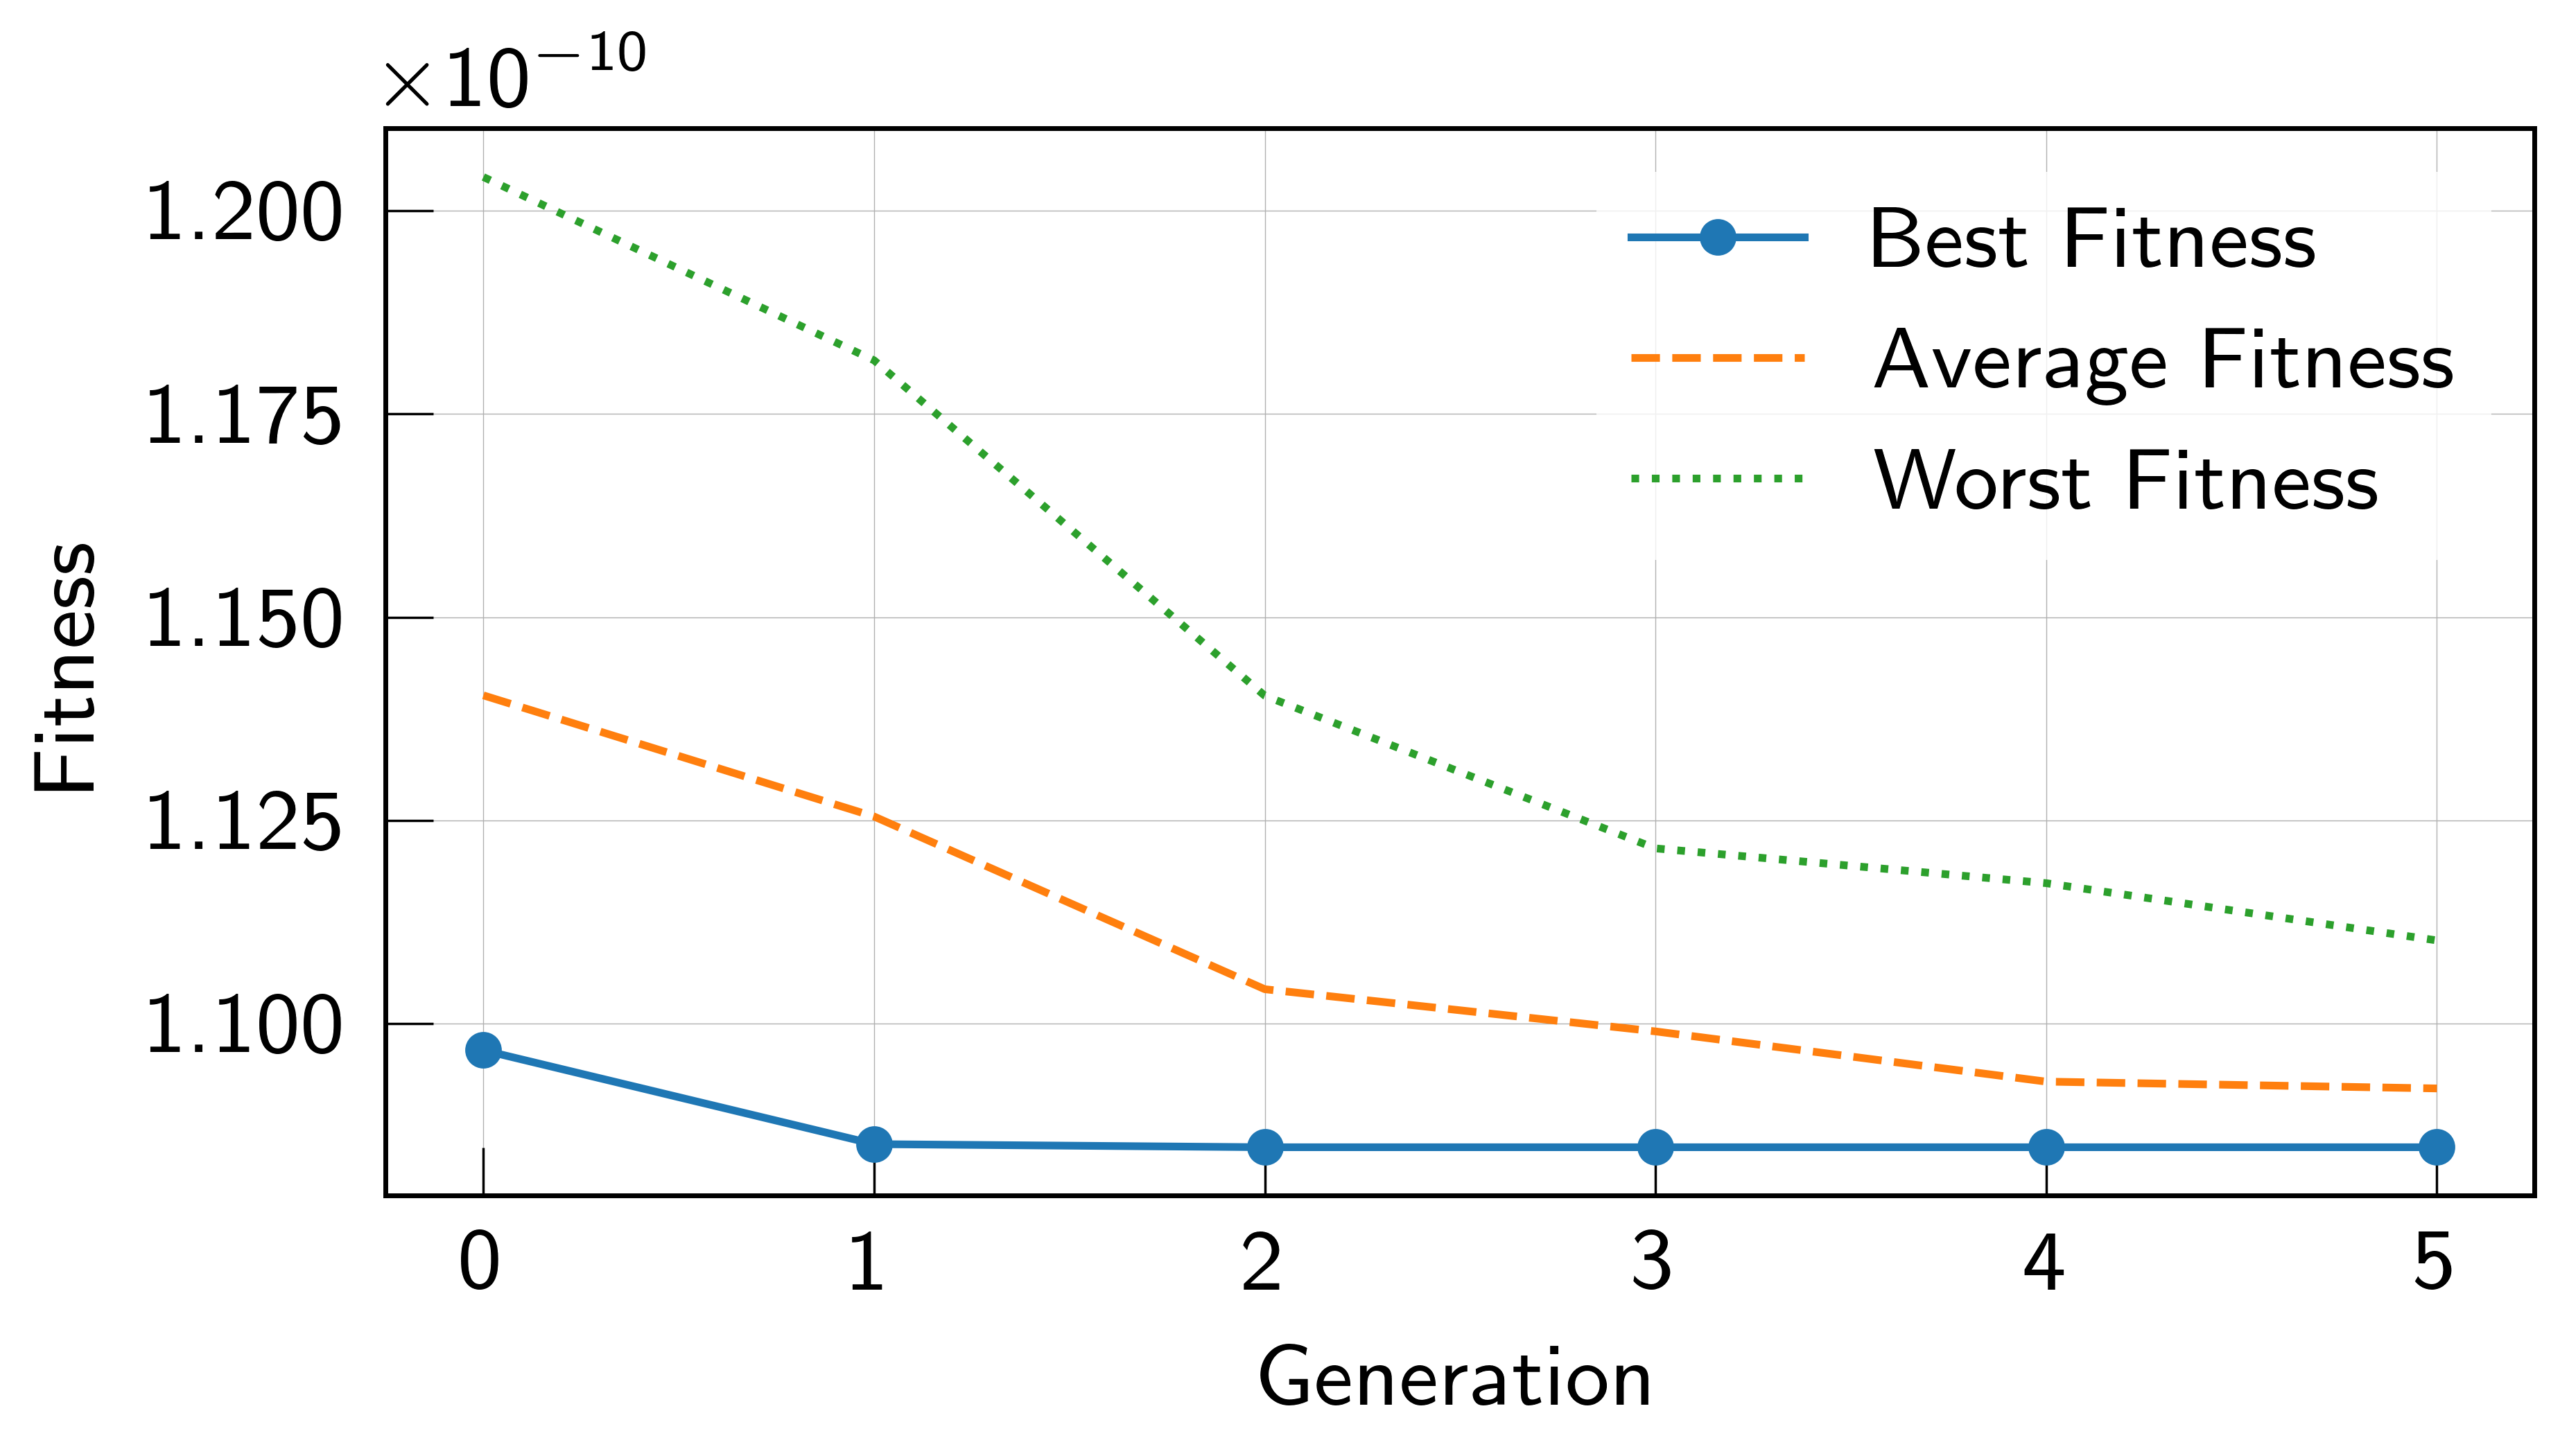

In [3]:
# plot fitness curve
import cm_vis
import matplotlib.pyplot as plt

plt.style.use('sans')
plot_fitness_curve('./history', plot_avg=True, plot_worst=True)

In [4]:
# plot best layouts
plot_best_layouts('./history', generations=[0, 1, 2, 3, 4,5])